# Bayesian Markov-Chain Monte Carlo Model Fitting 

https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

In [28]:
import numpy as np
import pylab as pl

## defining the data model

In [29]:
def model(x, p):
    return p[0] * np.exp(-(x/p[1])**2.) + p[2]

def model_vectorized(x, p):
    return p[0] * np.exp(-(np.outer(x, 1./p[1]))**2.) + p[2]

## creating a mock observation

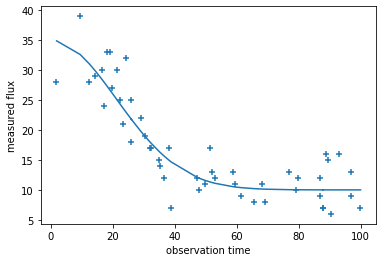

In [212]:
XERR = 0.2
X = np.sort(np.random.uniform(0, 100, 50))
P = np.array([25, 30, 10])
PRIORS = [[10, 40], [10, 50], [5, 15]]
# X is slighly randomized because we do not know the exact time of each observation
TRUE_X = X + np.random.uniform(size=X.size) * XERR
DATA = model(TRUE_X, P) # data is obtained at true times TRUE_X which are different than the measured time X

# simulation of CCD counts
TRUE_DATA = np.copy(DATA)
DATA = DATA.astype(int) 
DATA = np.random.poisson(lam=DATA)
pl.scatter(X, DATA, marker='+')
pl.xlabel('observation time')
pl.ylabel('measured flux')
pl.plot(TRUE_X, TRUE_DATA)

## classic least-square fit

In [213]:
import scipy.optimize

[26.28361063 28.49289343  9.70099614] [2.83360552 2.58674241 0.68888737]


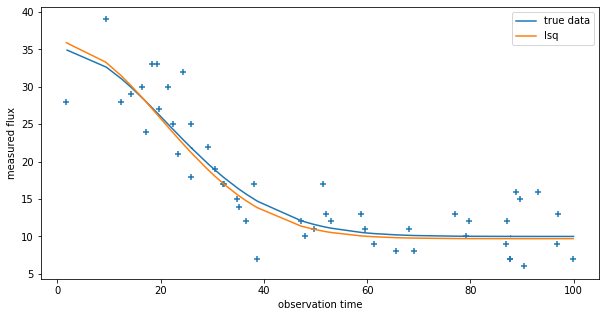

In [214]:
def residuals(p, x, data, data_err):
    return (data - model(x, p)) / data_err
p_init = np.mean(PRIORS, axis=1)
lsqfit = scipy.optimize.least_squares(residuals, p_init, args=(X, DATA, np.sqrt(DATA)))
J = lsqfit.jac
cov = np.linalg.inv(J.T.dot(J))
perr_lsq = np.sqrt(np.diagonal(cov))
p_lsq = lsqfit.x

print(p_lsq, perr_lsq)

pl.figure(figsize=(10,5))
pl.scatter(X, DATA, marker='+')
pl.xlabel('observation time')
pl.ylabel('measured flux')
pl.plot(TRUE_X, TRUE_DATA, label='true data')
pl.plot(X, model(X, p_lsq), label='lsq')
pl.legend()

## compute the uncertainty on the parameters by hand

$\sigma(p) = 2\left[\frac{\partial^2 \chi^2(p)}{\partial p^2}\right]^{-\frac{1}{2}}$ i.e. the square root of the inverse of the second derivative (curvature) of the objective function around the fitted value of p (i.e. the minimum of $\chi^2(p)$)

2.6962788071056822 2.8336055222997394
2.100434368742492 2.586742406106645
0.7318979009697606 0.6888873677476018


<Figure size 432x288 with 0 Axes>

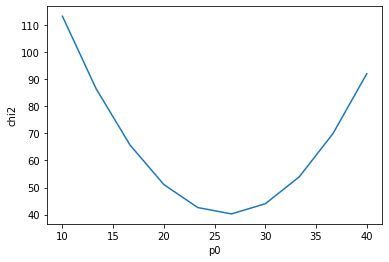

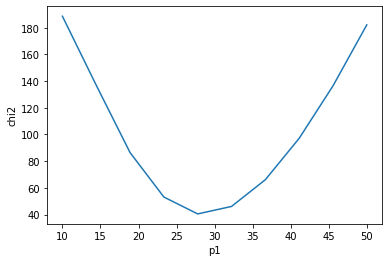

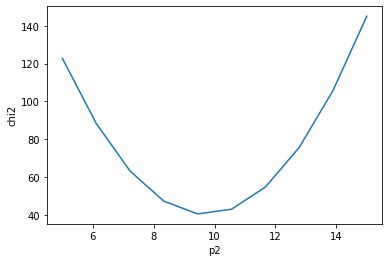

<Figure size 432x288 with 0 Axes>

In [215]:
def residuals_vectorized(p, x, data, data_err):
    chi2 = (np.atleast_2d(data).T - model_vectorized(x, p))**2 / (np.atleast_2d(data_err).T**2)
    return np.sum(chi2, axis=0)
 
    
def get_chi2(p_index):
    pi_grid = np.linspace(PRIORS[p_index][0], PRIORS[p_index][1], 10)
    p_grid = list()
    for i in range(3):
        if i == p_index:
            p_grid.append(pi_grid)
        else:
            p_grid.append(np.ones_like(pi_grid) * p_lsq[i])
    p_grid = np.array(p_grid)
    return pi_grid, residuals_vectorized(p_grid, X, DATA, np.sqrt(DATA))

def get_sigma(p_index):
    _x, _y = get_chi2(p_index)
    return 2*np.sqrt((1./np.gradient(np.gradient(_y, _x),_x))[np.argmin(_y)])
    
#pl.plot(p0_grid, res_grid)
#print(np.min((1./(np.gradient(np.gradient(res_grid, p0_grid), p0_grid)))))
print(get_sigma(0), perr_lsq[0])
print(get_sigma(1), perr_lsq[1])
print(get_sigma(2), perr_lsq[2])

pl.figure()
pl.plot(*get_chi2(0))
pl.xlabel('p0')
pl.ylabel('chi2')
pl.figure()
pl.plot(*get_chi2(1))
pl.xlabel('p1')
pl.ylabel('chi2')
pl.figure()
pl.plot(*get_chi2(2))
pl.xlabel('p2')
pl.ylabel('chi2')

pl.figure()

#pl.plot(_x, np.gradient(np.gradient(_y, _x), _x))
#pl.plot(_x, np.exp(-_y))

## Monte-Carlo bayesian fit

The idea is to estimate the distribution of the posterior probability P(PARAMETERS $\mid$ DATA).

P(PARAMETERS $\mid$ DATA) = $P$(DATA $\mid$ PARAMETERS) $\times$ $P$(PARAMETERS) / $P$(DATA).

- We know DATA and $P$(DATA) (the latter can be an estimate)
- We have vague constraints on the values of the PARAMETERS (e.g. we can say that the probability of each parameters is uniform between two bounding values), i.e. we have an a priori idea of $P$(PARAMETERS)
- We have a data model from which we can compute the data from a set of arbitrary parameters, i.e. we can obtain at least a proability distribution of $P$(DATA $\mid$ PARAMETERS) if we know $P$(PARAMETERS)

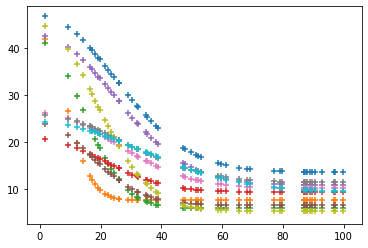

In [216]:

N = 1000000

def MC_sampling(x, priors, n):
    p_samples = [np.random.uniform(low=priors[0][0], high=priors[0][1], size=n),
                 np.random.uniform(low=priors[1][0], high=priors[1][1], size=n),
                 np.random.uniform(low=priors[2][0], high=priors[2][1], size=n)]
    
    return np.array(p_samples), model_vectorized(x, p_samples)

p_samples, models = MC_sampling(X, PRIORS, N)
for i in range(10):
    pl.scatter(X, models[:,i], marker='+')
    post_prob = models[:,i] 


In [217]:
def likelihood(models, data):
    chi2 = (np.atleast_2d(data).T - models)**2 / (2 * np.atleast_2d(np.sqrt(data)).T**2)
    chi2 = np.sum(chi2, axis=0)
    return np.exp(-chi2)
    #return #np.exp(-np.mean(chi2, axis=0))


lhood = likelihood(models, DATA)

## likelihood in 1d

Text(0, 0.5, 'likelihood')

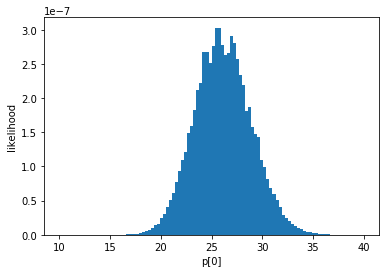

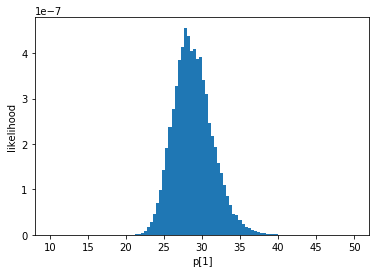

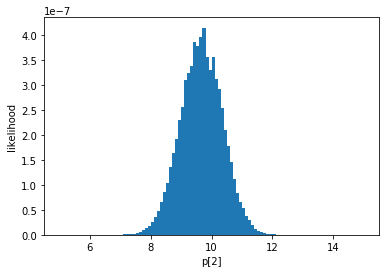

In [218]:
bins = 100
pl.figure()
pl.hist(p_samples[0,:], weights=lhood, bins=bins)
pl.xlabel('p[0]')
pl.ylabel('likelihood')

pl.figure()
pl.hist(p_samples[1,:], weights=lhood, bins=bins)
pl.xlabel('p[1]')
pl.ylabel('likelihood')

pl.figure()
pl.hist(p_samples[2,:], weights=lhood, bins=bins)
pl.xlabel('p[2]')
pl.ylabel('likelihood')


## likelihood in 2d

Text(0, 0.5, 'p[2]')

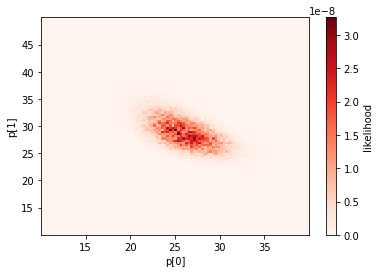

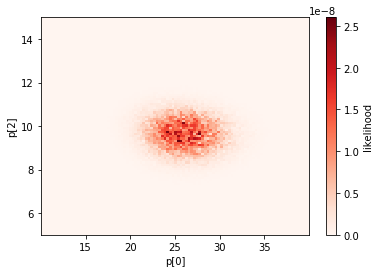

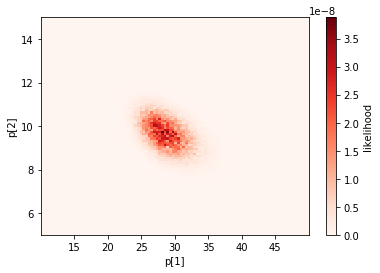

In [219]:


cmap = 'Reds'
bins = 100

pl.hist2d(p_samples[0,:], p_samples[1,:], weights=lhood, bins=bins, cmap=cmap)
cb = pl.colorbar()
cb.set_label('likelihood')
pl.xlabel('p[0]')
pl.ylabel('p[1]')

pl.figure()
pl.hist2d(p_samples[0,:], p_samples[2,:], weights=lhood, bins=bins, cmap=cmap)
cb = pl.colorbar()
cb.set_label('likelihood')
pl.xlabel('p[0]')
pl.ylabel('p[2]')

pl.figure()
pl.hist2d(p_samples[1,:], p_samples[2,:], weights=lhood, bins=bins, cmap=cmap)
cb = pl.colorbar()
cb.set_label('likelihood')
pl.xlabel('p[1]')
pl.ylabel('p[2]')



## in 3d

In [220]:
import k3d # https://github.com/K3D-tools/K3D-jupyter
import matplotlib.cm

In [221]:
plot = k3d.plot(height=600)
plot.grid_auto_fit = True
positions = p_samples.T.astype(np.float32)

cmap = matplotlib.cm.Reds

colors = np.copy(lhood)
print(colors)

PERC = 95
positions = positions[colors > np.nanpercentile(colors, PERC)]
colors = colors[colors > np.nanpercentile(colors, PERC)]

colors -= np.nanpercentile(colors, 1)
colors /= np.nanpercentile(colors, 99)
colors[colors < 0] = 0
colors[colors > 1] = 1

colors = colors**0.1 # nicer color scaling

rgbacolors = (cmap(colors) * 255).astype(np.uint32)
intcolors = rgbacolors[:,0]
intcolors = rgbacolors[:,0] << 16 | rgbacolors[:,1] << 8 | rgbacolors[:,2]
print(colors.shape)
print(p_samples.T.shape)


points = k3d.points(positions, colors=intcolors, point_size=1.5, shader='dot', opacity=0.1, legend=True)
plot += points
plot.display()


[3.63289089e-52 6.46522592e-49 3.71899365e-35 ... 1.01968190e-14
 1.90835294e-48 2.37874272e-40]
(50000,)
(1000000, 3)


Output()

##  MCMC results

p0=26.14 [2.78]
p1=28.85 [2.56]
p2=9.66 [0.69]


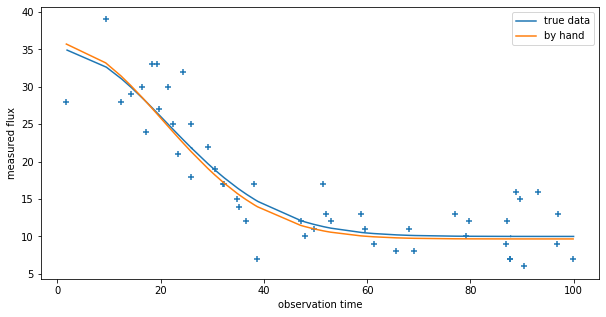

In [222]:
# parameter 1
def marginalization(index):
    pmean = np.average(p_samples[index,:], weights=lhood) # weighted mean
    # weighted std (note: biased version, see https://en.wikipedia.org/wiki/Weighted_arithmetic_mean)
    pstd = np.sqrt(np.average((p_samples[index,:] - pmean)**2, weights=lhood)) 
    return pmean, pstd

print('p0={:.2f} [{:.2f}]'.format(*marginalization(0)))
print('p1={:.2f} [{:.2f}]'.format(*marginalization(1)))
print('p2={:.2f} [{:.2f}]'.format(*marginalization(2)))

p_hand = [marginalization(0)[0], marginalization(1)[0], marginalization(2)[0]]
perr_hand = [marginalization(0)[1], marginalization(1)[1], marginalization(2)[1]]

pl.figure(figsize=(10,5))
pl.scatter(X, DATA, marker='+')
pl.xlabel('observation time')
pl.ylabel('measured flux')
pl.plot(TRUE_X, TRUE_DATA, label='true data')
pl.plot(X, model(X, p_hand), label='by hand')
pl.legend()

In [223]:
import pymc3 as pm # https://docs.pymc.io/
# https://docs.pymc.io/notebooks/getting_started.html

# note: do not forget to install Arviz : https://github.com/arviz-devs/arviz
# conda install -c conda-forge arviz

In [224]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    p0 = pm.Uniform('p0', lower=PRIORS[0][0], upper=PRIORS[0][1])
    p1 = pm.Uniform('p1', lower=PRIORS[1][0], upper=PRIORS[1][1])
    p2 = pm.Uniform('p2', lower=PRIORS[2][0], upper=PRIORS[2][1])

    # Likelihood (sampling distribution) of observations
    x_obs = pm.Normal('x_obs', mu=X, sigma=XERR, observed=X)
    
    # note that observation noise can be modeled with a Poisson statistics easily
    y_obs = pm.Poisson('y_obs', mu=model(x_obs, [p0, p1, p2]), observed=DATA)
    trace = pm.sample(5000, )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p2, p1, p0]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1234.51draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfbd8febd0>,
      dtype=object)

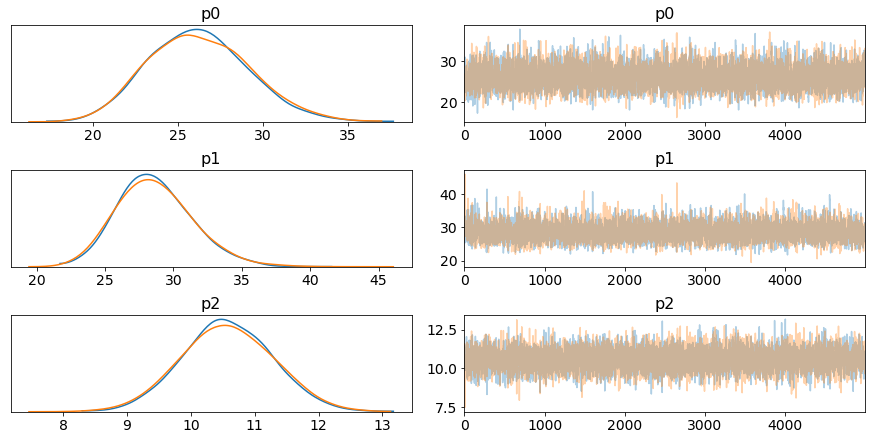

In [225]:
pm.traceplot(trace)

In [226]:
results = pm.summary(trace).round(2)
print(results)

     mean    sd  mc_error  hpd_2.5  hpd_97.5    n_eff  Rhat
p0  26.25  2.94      0.04    20.74     32.07  5989.76   1.0
p1  28.68  2.74      0.04    23.43     34.04  5144.93   1.0
p2  10.58  0.71      0.01     9.23     11.97  6078.33   1.0


/home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


In [227]:
p_pymc3 = results['mean'].values
perr_pymc3 = results['sd'].values

# methods comparison

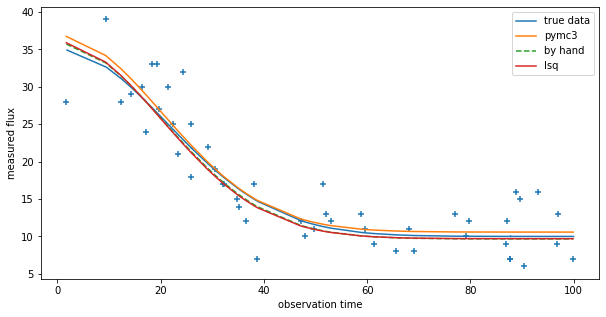

In [228]:
pl.figure(figsize=(10,5))
pl.scatter(X, DATA, marker='+')
pl.xlabel('observation time')
pl.ylabel('measured flux')
pl.plot(TRUE_X, TRUE_DATA, label='true data')
pl.plot(X, model(X, p_pymc3), label='pymc3')
pl.plot(X, model(X, p_hand), label='by hand', ls='--')
pl.plot(X, model(X, p_lsq), label='lsq', ls='-')
pl.legend()

In [229]:
print('SUMMARY')
print('lsq {:.2f} {:.2f} {:.2f} | {:.2f} {:.2f} {:.2f} '.format(*p_lsq, *perr_lsq))
print('pymc3 {:.2f} {:.2f} {:.2f} | {:.2f} {:.2f} {:.2f} '.format(*p_pymc3, *perr_pymc3))
print('hand {:.2f} {:.2f} {:.2f} | {:.2f} {:.2f} {:.2f} '.format(*p_hand, *perr_hand))


SUMMARY
lsq 26.28 28.49 9.70 | 2.83 2.59 0.69 
pymc3 26.25 28.68 10.58 | 2.94 2.74 0.71 
hand 26.14 28.85 9.66 | 2.78 2.56 0.69 


## plot the uncertainty for each method

[2.7801640322753327, 2.561883192934092, 0.6892152456217941]


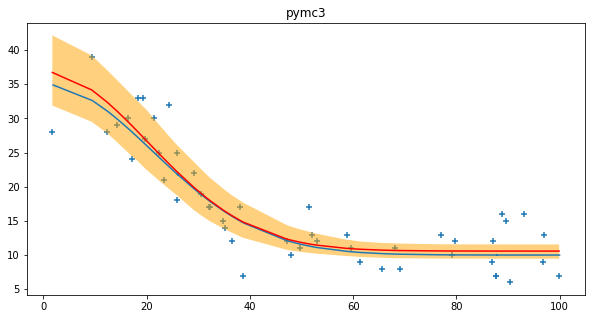

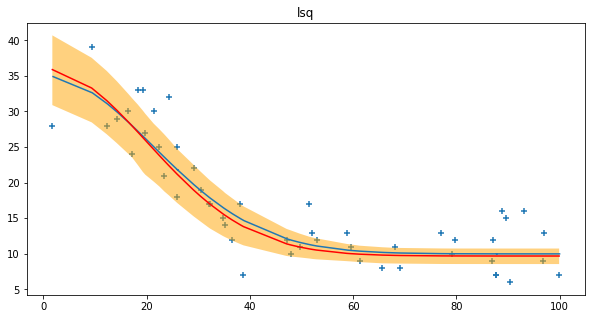

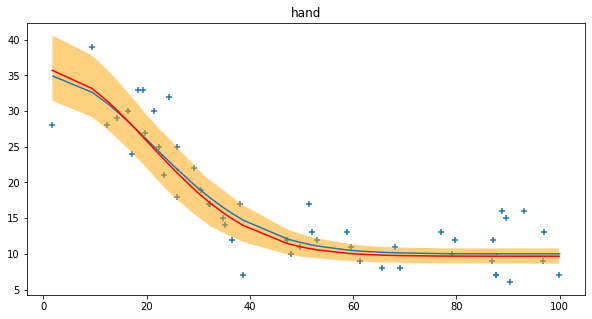

In [230]:
NPLOT = 300

def plot_method(p, p_err, title):
    
    pl.figure(figsize=(10,5))
    pl.scatter(X, DATA, marker='+')
    pl.plot(TRUE_X, TRUE_DATA, label='true data')
    models = list()
    for i in range(NPLOT):
        models.append(model(X, p + np.random.standard_normal(size=3) * p_err))
    bounds = np.nanpercentile(models, [5, 95], axis=0)
    pl.plot(X, model(X, p), c='red')
    pl.fill_between(X, bounds[0,:], bounds[1,:], facecolor='orange', alpha=0.5)
    pl.title(title)

print(perr_hand)
plot_method(p_pymc3, perr_pymc3, 'pymc3')
plot_method(p_lsq, perr_lsq, 'lsq')
plot_method(p_hand, perr_hand, 'hand')